# Mapserver / Mapfile

In [1]:
from IPython.display import HTML
from matplotlib import pyplot as plt
# local
from AlertaDengue.dados import dbdata
from AlertaDengue.AlertaDengue.settings import MAPSERVER_URL

import geopandas as gpd
import numpy as np
import os
import pyproj
import sqlalchemy as sqla
# local
import AlertaDengue as alert_dengue

## Setting variables

In [2]:
shp_path = '%s/static/shapefile' % alert_dengue.__path__[0]
local_mapfile_dir = '%s/mapfiles/%%s' % (
    os.path.dirname(alert_dengue.__path__[0])
)

ms_shp_path = '/shapefiles'
ms_error_path = '/var/log/mapserver.log'
ms_cgi_path = MAPSERVER_URL + '?map=%s&'
ms_mapfile_name = '%s.map'
ms_mapfile_dir = '/maps/%s'

### Define Brazil's boundaries

In [3]:
def extract_boundaries(gdf: gpd.GeoDataFrame):
    """
    """
    bound_min = gdf.bounds[['minx', 'miny']].min()
    bound_max = gdf.bounds[['maxx', 'maxy']].max()
    bounds = np.array((bound_min, bound_max)).flatten()
    return bounds


def stringfy_boundaries(bounds: np.array, sep=' '):
    str_boundaries = [str(v) for v in bounds]
    return sep.join(str_boundaries)


def calc_layer_width_by_boundaries(bounds: np.array, layer_height: int=400):
    # ratio size
    width = np.abs(bounds[0] - bounds[2])
    height = np.abs(bounds[1] - bounds[3])
    
    ratio_size =  width / height

    return layer_height * ratio_size

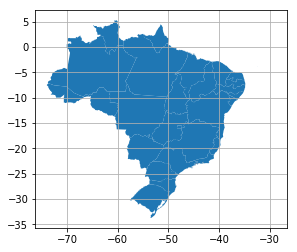

In [4]:
# Getting general info geo from Brazil
gdf_brazil = gpd.GeoDataFrame.from_file(
    os.path.join(shp_path, '%s.shp' % 'UFEBRASIL')
)
gdf_brazil.plot()

plt.grid(True)
plt.show()

In [5]:
# http://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/
# LatLon with WGS84 datum used by GPS units and Google Earth
wgs84 = pyproj.Proj("+init=EPSG:4326")
grs80 = pyproj.Proj("+init=EPSG:2154")

In [6]:
# boundaries in epsg:2154
bounds = extract_boundaries(gdf_brazil)
bounds

array([-73.99044997, -33.75208127, -28.83590763,   5.27184108])

In [7]:
# boundaries in epsg:4326
bounds[0], bounds[1] = pyproj.transform(grs80, wgs84, bounds[0], bounds[1])
bounds[2], bounds[3] = pyproj.transform(grs80, wgs84, bounds[2], bounds[3])
bounds

array([-1.36352984, -5.98409199, -1.36326239, -5.98383341])

In [8]:
extent_brazil = stringfy_boundaries(bounds=bounds, sep=' ')
extent_url_brazil = stringfy_boundaries(bounds=bounds, sep=',')
extent_url_brazil

'-1.36352983863,-5.98409199269,-1.36326239179,-5.98383341109'

In [9]:
# crs/srs
gdf_brazil.crs

{'ellps': 'GRS80', 'no_defs': True, 'proj': 'longlat'}

In [10]:
crs_proj_brazil = 'epsg:2154'
wms_srs_brazil = crs_proj_brazil.upper()

In [11]:
diseases = ('dengue', 'chikungunya')

In [12]:
alert_colors = [
    '#00FF00',
    '#FFFF00',
    '#FF9900',
    '#FF0000',
]

## DB connection

In [13]:
def get_passwd_from_ini(filepath: str):
    with open(filepath) as f:
        text = f.read()
        i = text.index('PSQL_PASSWORD')
        f = text[i:].index('\n')
        passwd = text[i:i+f].split('=')
        return passwd[1].strip()
    

In [14]:
db = 'dengue'
user = 'dengueadmin'
host = 'localhost'
passwd = get_passwd_from_ini('../AlertaDengue/AlertaDengue/settings.ini')
dsn = "postgresql://{}:{}@{}/{}".format(
    user, passwd, host, db
)

engine = sqla.create_engine(dsn)

## Mapfile

### Templates

In [15]:
# mapfile templates

mapfile_template = '''
MAP
    # The geographic extent (the rectangular area covered by the map) is 
    # defined by the keyword EXTENT. The rectangular area is specified by
    # the coordinates of the opposite corners (the lower left and the upper 
    # right). These are coordinates of the southwest and the northeast corners 
    # EX:
    # EXTENT -125.00 20.00 -65.00 50.00
    # The geographic extent stretches from 125° west, 20° north to 65° west, 
    # 50° north.
    
    CONFIG 'ON_MISSING_DATA' 'IGNORE'
    CONFIG 'PROJ_LIB' './conf/'
    CONFIG      "MS_ERRORFILE" "%(ms_error_path)s"
    CONFIG      "CPL_DEBUG" "ON"
    CONFIG      "PROJ_DEBUG" "ON"
    DEBUG       5
    
    NAME        "MAP_%(mapfile_name)s"
    
    IMAGETYPE   png
    IMAGECOLOR  0 0 0
    MAXSIZE     4000
    SIZE        800 800
    UNITS       meters
    EXTENT %(extent)s
       
    OUTPUTFORMAT
      NAME      "png"
      DRIVER    AGG/PNG
      MIMETYPE  "image/png"
      IMAGEMODE RGBA
      EXTENSION "png"
      FORMATOPTION "GAMMA=0.75"
    END
    
    OUTPUTFORMAT
      NAME "GTiff"
      DRIVER GDAL/GTiff
      MIMETYPE "image/tiff"
      IMAGEMODE RGBA
      EXTENSION "tiff"
      FORMATOPTION 'ATTACHMENT=%(mapfile_name)s.tiff'
    END
    
    OUTPUTFORMAT
      NAME kml
      DRIVER "KML"
      MIMETYPE "application/vnd.google-earth.kml+xml"
      IMAGEMODE RGBA
      EXTENSION "kml"
      FORMATOPTION 'ATTACHMENT=%(mapfile_name)s.kml'
    END

    PROJECTION
        "init=%(crs_proj)s"
    END

    WEB
      METADATA
        "wms_title" "Alerta %(disease_title)s"
        "wms_onlineresource" "%(ms_cgi_path)s"
        "wms_enable_request" "*"
        "wms_srs" "%(wms_srs)s EPSG:4326 EPSG:3857"
        "labelcache_map_edge_buffer" "-10"
        # "wms_feature_info_mime_type" "text/html"
        # "wms_format" "image/png"
      END
      
      IMAGEPATH '/tmp/map/%(disease)s/'
      IMAGEURL '/mapimg/%(disease)s/'

    END
    
    SHAPEPATH '%(shp_path)s/'
 
%(include_layers)s
 
END
'''

mapfile_layer_template = '''
    LAYER
        NAME         "%(layer_name)s"
        DATA         "%(geocode)s"
        STATUS       ON
        TYPE         POLYGON
        # OFFSITE      0 0 0
        
        TEMPLATE "conf/template.html"
        
        PROJECTION
          "init=%(crs_proj)s"
        END
        
        METADATA
          "wms_title" "%(city_name)s"
          "wms_srs" "%(wms_srs)s EPSG:3857"
          "wms_include_items" "all" 
        END
        
        COMPOSITE
            OPACITY 60
        END # COMPOSITE
 
        CLASS
            STYLE
                COLOR '%(rgb)s'
            END
        END
    END
'''

### Generating the mapfile

In [16]:
sql_template = '''
SELECT geocodigo, nome, uf 
FROM "Dengue_global"."Municipio" 
WHERE uf = '%s'
ORDER BY nome;
'''

In [17]:
state_initials = {
    'Paraná': 'PR', 
    'Rio de Janeiro': 'RJ', 
    'Ceará': 'CE', 
    'Minas Gerais': 'MG', 
    'Espírito Santo': 'ES'
}

In [18]:
# prepare mapfile
layer_height = 400

layers = {}
state_bounds = {}
cities_conf = []

template_url = (
    MAPSERVER_URL + '?' + 
    'map=/maps/dengue.map&' + 
    'SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&' +
    'STYLES=&CRS=%(crs_url)s&BBOX=%(bbox)s&' +
    'WIDTH=%(width)s&HEIGHT=%(height)s&FORMAT=%%(format)s&LAYERS=%(layer_name)s'
)
url_cities = []

for disease in diseases:
    layers[disease] = {}
    state_bounds[disease] = {}
    
    # layers by state
    for state_name in state_initials.keys():
        with engine.connect() as conn:
            sql = sql_template % state_name
            result = conn.execute(sql).fetchall()

        cities_alert = dbdata.NotificationResume.get_cities_alert_by_state(
            state_name, disease
        )

        alerts = dict(
            cities_alert[['municipio_geocodigo', 'level_alert']].values
        )
        
        layers[disease][state_name] = []
        state_cities_selected = 0
        
        for geocode, city_name, state_country in result:
            # getting shapefile settings
            shapefile_path = os.path.join(shp_path, '%s.shp' % geocode)
            
            if not os.path.exists(shapefile_path):
                continue
            
            gdf = gpd.GeoDataFrame.from_file(shapefile_path)
            
            crs_proj = gdf.crs['init']
            wms_srs = crs_proj.upper()
            bounds = extract_boundaries(gdf)
            
            layer_bbox = stringfy_boundaries(bounds=bounds, sep=',')
            layer_width = calc_layer_width_by_boundaries(
                bounds=bounds, layer_height=layer_height
            )

            alert_level = alerts[geocode] if geocode in alerts else -1
            # print(alert_level)
            alert_color = (
                alert_colors[alert_level] if 0 <= alert_level <= 3 else
                '#DFDFDF'  # gray
            )
            
            layer_name = city_name.upper().replace(' ', '_')
            
            layer_conf = {
                'geocode': geocode,
                'city_name': city_name,
                'layer_name': layer_name,
                'rgb': alert_color,
                'wms_srs': wms_srs,
                'crs_proj': crs_proj,
                'crs_url': (
                    crs_proj if not crs_proj.upper() == 'EPSG:4326' else
                    'CRS:84'
                ),
                'bbox': layer_bbox,
                'width': layer_width,
                'height': layer_height
            }
            
            layers[disease][state_name] += [layer_conf]
            
            url_cities.append(
                template_url % layer_conf
            )
            
            # JUST FOR TEST
            if (
                disease == 'dengue' and
                state_cities_selected <= 5 and 
                bool(np.random.randint(0,2))
            ):
                cities_conf.append({
                    'layer_name': layer_name, 
                    'city_name': city_name
                })
                
                state_cities_selected += 1

In [19]:
# save mapfile

include_layers = {}
include_template = (
    '    INCLUDE "layers/%(disease)s/%(layer_name)s"  # %(city_name)s\n'
)

# save individual layers
for disease, states_layer in layers.items():
    include_layers[disease] = {}
    
    layer_path_disease = local_mapfile_dir % (
        'layers/%s/%%s' % disease
    )
    
    disease_title = disease.title()
    
    if not os.path.exists(layer_path_disease):
        os.makedirs(layer_path_disease)
    
    for state_name, layers_conf in states_layer.items():
        include_layers[disease][state_name] = ''
        for layer_conf in layers_conf:
            layer_content = mapfile_layer_template % layer_conf
            layer_name = '%s.map' % layer_conf['geocode']
            layer_path = layer_path_disease % layer_name
            
            include_layer = include_template % {
                'disease': disease,
                'layer_name': layer_name, 
                'city_name': layer_conf['city_name']
            }
            
            # @deprecated: this check was done before
            if not os.path.exists(
                os.path.join(shp_path, '%s.shp' % layer_conf['geocode'])
            ):
                include_layer = '#' + include_layer

            include_layers[disease][state_name] += include_layer

            with open(layer_path, 'w') as f:
                f.write(layer_content)
    
    # save mapfile with all cities
    mapfile_name = ms_mapfile_name % disease
    mapfile_path = local_mapfile_dir % mapfile_name
    ms_mapfile_path = ms_mapfile_dir % mapfile_name
    
    ms_config = {
        'include_layers': ''.join(include_layers[disease].values()),
        'ms_error_path': ms_error_path,
        'ms_cgi_path': ms_cgi_path % ms_mapfile_path,
        'shp_path': ms_shp_path,
        'extent': extent_brazil,
        'mapfile_name': 'INFO_DENGUE',
        'wms_srs': wms_srs_brazil,
        'crs_proj': crs_proj_brazil,
        'disease': disease,
        'disease_title': disease_title
    }
    
    mapfile_content = mapfile_template % ms_config
    
    print('Saving ', mapfile_path, 'file ...')
    with open(mapfile_path, 'w') as f:
        f.write(mapfile_content)

print('[II] DONE!')

Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/dengue.map file ...
Saving  /home/xmn/dev/AlertaDengue/AlertaDengue/mapfiles/chikungunya.map file ...
[II] DONE!


## Visualizing the map

### Service's links

In [20]:
output_formats = ['png', 'kml', 'gtiff']
output_urls = ''

for output_format in output_formats:
    output_urls += '<hr/><h1>%s</h1>' % output_format
    for url in url_cities:
        _url = url % {'format': output_format}
        output_urls += '* %(url)s<br/>\n' % {'url': _url}
        
HTML('''
<div 
  style="font-size:10px;width:600px;height:300px;word-break:break-all">
  %s
</div>''' % output_urls)

### Map visualization test

In [21]:
HTML('''
<script type="text/javascript">
    var extent_url = '%s';
    var crs_proj = '%s';
    var disease = 'dengue';
    var cities_conf = %s;
    var mapserverURL = '%s';
</script>
''' % (extent_url_brazil, crs_proj_brazil, cities_conf, MAPSERVER_URL))

In [22]:
%%html

<div id="alerta_dengue" style="height: 400px; width: 800px;"></div>

<link rel="stylesheet" href="lib/leaflet/leaflet.css" />
<script type="text/javascript" src="lib/leaflet/leaflet.js"></script>

<script>

var mapfile_url = '';
var osmUrl='http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png';
var osmAttrib = 'Map data © <a href="http://openstreetmap.org">OpenStreetMap</a> contributors';

var minZoom = 3;
var maxZoom = 11;
var zoom = 3;

var overlayMaps = {};

//# openstreetmap
osm = L.tileLayer(osmUrl, {
    attribution: osmAttrib,
    crs: L.CRS.EPSG4326,
    minZoom: minZoom,
    maxZoom: maxZoom
});

var baseMap = {
    "OSM": osm
};

var map = L.map(
    'alerta_dengue', {
        //crs: L.CRS.EPSG4326,
        center: new L.LatLng(-22.9192,-43.4441),
        zoom: zoom,
        layers: [osm]
    }
); 

mapfile_url = (
    mapserverURL + '?' + 
    'map=/maps/dengue.map&' + 
    'SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&' +
    'STYLES=&CRS=CRS:84&BBOX=' + extent_url + '&' +
    'WIDTH=600&HEIGHT=300&FORMAT=png&LAYERS='
);

console.log(mapfile_url);

var city_name;
var layer_name;

for (i in cities_conf) {
    city_name = cities_conf[i]['city_name'];
    layer_name = cities_conf[i]['layer_name'];
    //# mapserver
    console.log(mapfile_url + layer_name);
    ms = L.tileLayer.wms(mapfile_url + layer_name, {
        layers: layer_name,
        format: 'image/png',
        transparent: true,
        attribution: "Info Dengue",
        srs:"EPSG:4326",
        crs: L.CRS.EPSG4326,
        minZoom: minZoom,
        maxZoom: maxZoom,
    });

    overlayMaps[city_name] = ms;
}

L.control.layers(baseMap, overlayMaps).addTo(map);

</script>